In [1]:
#pip install ipykernel
#pip install pygame numpy pydub noisereduce scipy requests tabulate transformers pandas wheel gradio
#pip install torch torchvision torchaudio
#pip install kenlm pyctcdecode

SHOW_WEBSITE = True

numbers = {}

numbers["INITIAL_displayed_lines"] = 2
numbers["INITIAL_starting_line"]   = 0
numbers["INITIAL_stoping_line"]    = numbers["INITIAL_starting_line"] + numbers["INITIAL_displayed_lines"] 



In [2]:
print("""
#-0-###########################       Loading : Imports                       ########################################
""")

#Génériques
import os, random, csv, time, pygame, warnings, copy
from tabulate import tabulate


from pydub import AudioSegment
import numpy as np
import noisereduce as nr
from scipy.signal import butter, lfilter
import requests

from transformers import pipeline

#spécifiques
import numpy                as np
import pandas               as pd
import matplotlib.pyplot    as plt


#-0-###########################       Loading : Imports                       ########################################

pygame 2.5.2 (SDL 2.28.3, Python 3.12.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\thiba\OneDrive - Ecole de l'air\USAFA IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("#-1-###########################       Loading : Functions                       ########################################")

#-1-###########################       Loading : Functions                       ########################################


In [4]:
print("#-1.1-#### Audio functions")

def download_mp3(url, output_path):
    # Send a GET request to the URL
    response = requests.get(url, stream=True)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Open a file for writing the binary data of the audio file
        with open(output_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                file.write(chunk)
        print(f"{output_path} DOWNLOAD complete")
    else:
        print("Failed to retrieve the file from the URL.")

def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

import numpy as np
import matplotlib.pyplot as plt

def plot_fourier_transform(audio_signal, sample_rate):
    # Calculate the Fourier Transform of the audio signal
    n = len(audio_signal)  # Length of the signal
    yf = np.fft.fft(audio_signal)
    xf = np.fft.fftfreq(n, 1 / sample_rate)  # Frequency bins

    # Plotting the Magnitude Spectrum
    plt.figure(figsize=(10, 4))
    plt.plot(xf, np.abs(yf))
    plt.title('Fourier Transform - Magnitude Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.xlim(0, sample_rate / 2)  # Only plot the positive frequencies
    plt.show()


def save_np_array_to_mp3(np_array, title, index):
    # Convert the numpy array back to pydub audio segment
    processed_audio_NR = AudioSegment(
        data=np_array.tobytes(), 
        sample_width=audio.sample_width, 
        frame_rate=audio.frame_rate, 
        channels=1
    )
    processed_audio_NR.export("./mp3/" + str(index) + "_" + title + ".mp3", format="mp3")

def make_reduced_noise_version(audio, index):
    samples = np.array(audio.get_array_of_samples())                 # Convert pydub AudioSegment to numpy array
    reduced_noise = nr.reduce_noise(y=samples, sr=audio.frame_rate)  # Assuming the audio is already loaded as a waveform `samples` with a sampling rate `rate`

    save_np_array_to_mp3(reduced_noise, 'noise_reduced', index)

    return reduced_noise

def make_improved_version(audio, reduced_noise, index):
    filtered_data = butter_lowpass_filter(reduced_noise, cutoff=3000, fs=audio.frame_rate)  # Apply a lowpass filter

    save_np_array_to_mp3(filtered_data, 'improved', index)

    return

#-1.1-#### Audio functions


In [5]:
print("#-1.2-#### Audio To Text functions")


def transcribe_audio(audio_file_path, summerize=True):
    transcriptions = {}

    for name, pipe_T in pipes["transcribe"].items():
        try:
            # Assurez-vous d'accéder au résultat de transcription correctement
            full_text  = pipe_T(audio_file_path)['text']
            transcriptions[name] = full_text

            if summerize :
                summerized = summarize_me(full_text)
                transcriptions["Summerized " + name] = summerized

        except Exception as e:
            transcriptions[name] = f"Erreur de transcription: {str(e)}"
            transcriptions["Summarized " + name] = f"Erreur de résumé: {str(e)}"
        
    return [transcriptions[key] for key in transcriptions.keys()]

#-1.2-#### Audio To Text functions


In [6]:
print("#-1.3-#### Text To Text functions")

def summarize_me(text_sent):
    return pipes["summerize"]["facebook/bart-large-cnn"](text_sent, max_length=50, min_length=10, do_sample=False)[0]['summary_text']


#-1.3-#### Text To Text functions


In [7]:
print("""
#-2-###########################       Loading CSV file                       ########################################
""")

#URL CSV
url_fichier_csv = "Data/liste_liveATC_use.csv"

Biblio_ATC_ORIGINAL = pd.read_csv(url_fichier_csv, delimiter=';')

numbers["total_file_lines"]   = Biblio_ATC_ORIGINAL.shape[0]
numbers["total_file_columns"] = Biblio_ATC_ORIGINAL.shape[1]

print("Biblio ATC loaded")
print(str(numbers["total_file_lines"] ) + " lines * " + str(numbers["total_file_columns"]) + " colums")

start_l = numbers["INITIAL_starting_line"]
stop_l  = numbers["INITIAL_stoping_line"]

Biblio_ATC_USE = Biblio_ATC_ORIGINAL.iloc[start_l:stop_l]

print("Biblio ATC limited to :")
print(str(numbers["INITIAL_displayed_lines"]) + " lines * " + str(numbers["total_file_columns"]) + " colums")


#-2-###########################       Loading CSV file                       ########################################

Biblio ATC loaded
4076 lines * 4 colums
Biblio ATC limited to :
2 lines * 4 colums


In [8]:
print("""
#-3-###########################       Loading pipes                       ########################################
""")



pipes = {}

pipes["transcribe"]      = {}
pipes["transcribe"]["Jzuluaga__wav2vec2-large-960h-lv60-self-en-atc-atcosim"] = pipeline("automatic-speech-recognition", model="Jzuluaga/wav2vec2-large-960h-lv60-self-en-atc-atcosim")
pipes["transcribe"]["facebook__wav2vec2-base-960h"]                           = pipeline("automatic-speech-recognition", model="facebook/wav2vec2-base-960h")
pipes["transcribe"]["scy0208__whisper-aviation-base"]                         = pipeline("automatic-speech-recognition", model="scy0208/whisper-aviation-base")
pipes["transcribe"]["billodal__whisper-small-atc"]                            = pipeline("automatic-speech-recognition", model="billodal/whisper-small-atc", return_timestamps=False)  

pipes["summerize"]       = {}
pipes["summerize"]["facebook__bart-large-cnn"] = pipeline("summarization", model="facebook/bart-large-cnn")

pipes["text-generation"] = {}
#pipes["text-generation"]["meta-llama__Meta-Llama-3-8B"] = pipeline("text-generation", model="meta-llama/Meta-Llama-3-70B")
                     


#-3-###########################       Loading pipes                       ########################################



Some weights of the model checkpoint at Jzuluaga/wav2vec2-large-960h-lv60-self-en-atc-atcosim were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at Jzuluaga/wav2vec2-large-960h-lv60-self-en-atc-atcosim and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weig

In [9]:
print("""
#-4-###########################       Downloading mp3 and converting                    ########################################
""")
for index, row in Biblio_ATC_USE.iterrows():
    url = row.iloc[1]
    output_path_mp3 = "./mp3/" + str(index) + ".mp3"

    #If the file already exists, we don't download it again
    if not (os.path.exists(output_path_mp3 )):
        try:
            download_mp3(url, output_path_mp3)
            audio = AudioSegment.from_file(output_path_mp3, format="mp3")
            reduced_noise = make_reduced_noise_version(audio, index)
            make_improved_version(audio, reduced_noise, index)
        except Exception as e:
            print(f"Erreur {output_path_mp3}: {str(e)}")
    else :
        print(output_path_mp3 + " ALREADY exists")


#-4-###########################       Downloading mp3 and converting                    ########################################

./mp3/0.mp3 ALREADY exists
./mp3/1.mp3 ALREADY exists


In [10]:
print("""
#-5-###########################       Transcribing                    ########################################
""")

for index, row in Biblio_ATC_USE.iterrows():
    url = row.iloc[1]
    input_paths = ["./mp3/" + str(index) + ".mp3",
                   "./mp3/" + str(index) + "_noise_reduced.mp3"]

    for mp3_file in input_paths :
        #If the audio exists
        if (os.path.exists(mp3_file)):

            for name, pipe_T in pipes["transcribe"].items():
                
                file_name_without_extension = mp3_file.split('/')[-1].split('.')[0]
                output_path_txt = "./transcribes/" + file_name_without_extension + "_" + name + ".txt"

                if not (os.path.exists(output_path_txt)):

                    try:
                        transcribe = pipe_T(mp3_file)['text']
                        with open(output_path_txt, 'w') as fichier:
                            fichier.write(transcribe)
                        print(output_path_txt + " crée")
            
                    except Exception as e:
                        print(f"Erreur {output_path_txt}: {str(e)}")

                else :
                    print(output_path_txt + " existe déja - skipped")
                    
        else :
            print(mp3_file + " n'existe pas, impossible de le transcrire")


#-5-###########################       Transcribing                    ########################################

./transcribes/0_Jzuluaga__wav2vec2-large-960h-lv60-self-en-atc-atcosim.txt existe déja - skipped
./transcribes/0_facebook__wav2vec2-base-960h.txt existe déja - skipped
./transcribes/0_scy0208__whisper-aviation-base.txt existe déja - skipped
Erreur ./transcribes/0_billodal__whisper-small-atc.txt: You are trying to return timestamps, but the generation config is not properly set. Make sure to initialize the generation config with the correct attributes that are needed such as `no_timestamps_token_id`. For more details on how to generate the approtiate config, refer to https://github.com/huggingface/transformers/issues/21878#issuecomment-1451902363
./transcribes/0_noise_reduced_Jzuluaga__wav2vec2-large-960h-lv60-self-en-atc-atcosim.txt existe déja - skipped
./transcribes/0_noise_reduced_facebook__wav2vec2-base-960h.txt existe déja - skipped
./transcribes/0_noise_reduced_scy0208

In [11]:
MP3_versions = ["", "_noise_reduced"]


if SHOW_WEBSITE:
    start_l  = numbers["INITIAL_starting_line"]
    stop_l   = numbers["INITIAL_stoping_line"] 
    

    import gradio as gr

    with gr.Blocks() as demo:

        for index in range(start_l, stop_l ) :
            with gr.Row():
                audio_file_path               = "./mp3/" + str(index) + ".mp3"
                audio_file_path_noise_reduced = "./mp3/" + str(index) + "_noise_reduced.mp3"
                text_file_path                = "./transcribes/" + str(index) + "_scy0208__whisper-aviation-base.txt"
                text_file_path_noise_reduced  = "./transcribes/" + str(index) + "_noise_reduced_scy0208__whisper-aviation-base.txt"

                try:
                    with open(text_file_path, 'r') as file:
                        text_orig = file.readlines()
                
                except Exception as e:
                    text_orig =  f"Error: {str(e)}"

                try:
                    with open(text_file_path_noise_reduced, 'r') as file:
                        text_noise_reduced = file.readlines()
                
                except Exception as e:
                    text_noise_reduced =  f"Error: {str(e)}"
                
                audio_orig          = gr.Audio(value = audio_file_path,               label=audio_file_path)
                audio_noise_reduced = gr.Audio(value = audio_file_path_noise_reduced, label=audio_file_path_noise_reduced)

                text_orig           = gr.Textbox(value=text_orig, label=text_file_path)
                text_noise_reduced  = gr.Textbox(value=text_noise_reduced, label=text_file_path_noise_reduced)

    demo.launch(share = True )




Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://f6f3641d3b91ae33ac.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


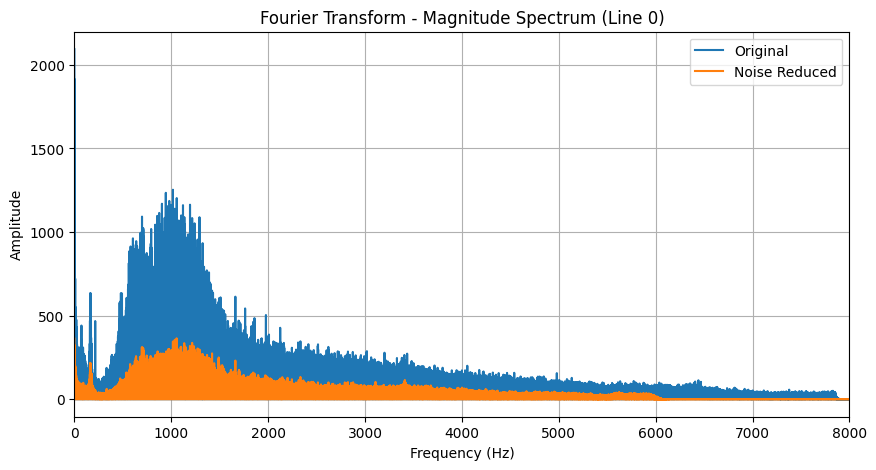

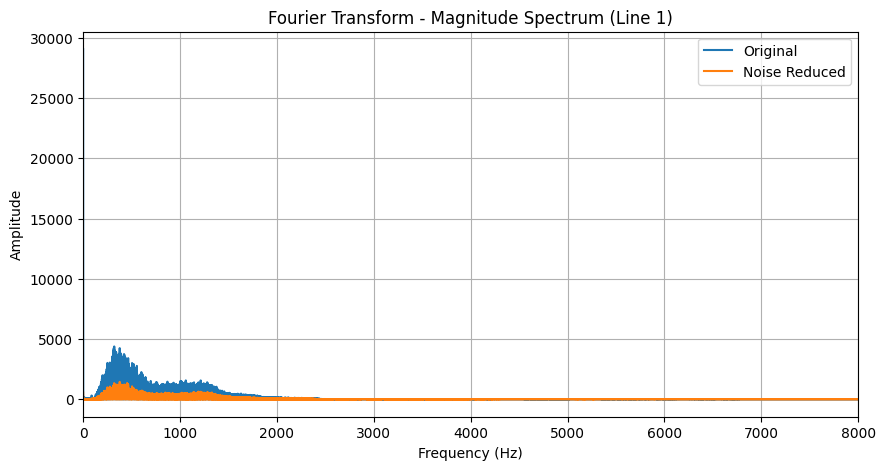

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment

def plot_fourier_transform(samples, sample_rate, label):
    # Calculate the Fourier Transform of the audio signal
    n = len(samples)  # Length of the signal
    yf = np.fft.fft(samples)
    xf = np.fft.fftfreq(n, 1 / sample_rate)  # Frequency bins

    # Plotting the Magnitude Spectrum
    plt.plot(xf, np.abs(yf), label=label)

def display_fourier_plots(start_line, stop_line, sample_rate):
    for index in range(start_line, stop_line):
        plt.figure(figsize=(10, 5))  # Create a new figure for each pair of audio files

        # Plot the original audio
        audio_file_path = f"./mp3/{index}.mp3"
        audio = AudioSegment.from_file(audio_file_path, format="mp3")
        samples = np.array(audio.get_array_of_samples())
        samples = samples / np.iinfo(samples.dtype).max  # Normalize
        plot_fourier_transform(samples, sample_rate, label="Original")

        # Plot the noise reduced audio
        audio_file_path_noise_reduced = f"./mp3/{index}_noise_reduced.mp3"
        audio_noise_reduced = AudioSegment.from_file(audio_file_path_noise_reduced, format="mp3")
        samples_noise_reduced = np.array(audio_noise_reduced.get_array_of_samples())
        samples_noise_reduced = samples_noise_reduced / np.iinfo(samples_noise_reduced.dtype).max  # Normalize
        plot_fourier_transform(samples_noise_reduced, sample_rate, label="Noise Reduced")

        # Setup plot details
        plt.title(f'Fourier Transform - Magnitude Spectrum (Line {index})')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.xlim(0, sample_rate / 2)  # Only plot the positive frequencies
        plt.show()

# Example usage
start_l = numbers["INITIAL_starting_line"]
stop_l =  numbers["INITIAL_stoping_line"]
sample_rate = 16000
display_fourier_plots(start_l, stop_l, sample_rate)
